In [66]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.metrics import (f1_score)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [8]:
full_training_data_wt = pd.read_csv('Nata_Files/processed/train_dataset.csv', index_col=0)
full_testing_data_wt = pd.read_csv('Nata_Files/processed/test_dataset.csv', index_col=0)
full_prediction_data = pd.read_csv('Nata_Files/processed/pred_scaled.csv', index_col=0)

In [81]:
X_train = full_training_data_wt.drop(['oven_temp', 'target'], axis=1) #dropping redundant feature
prediction_data = full_prediction_data.drop('oven_temp', axis=1)
y_train = full_training_data_wt['target']
X_test = full_testing_data_wt.drop(['oven_temp', 'target'], axis=1) #dropping redundant feature
y_test = full_testing_data_wt['target']

In [110]:
rf_best = RandomForestClassifier(n_estimators=100, max_leaf_nodes=164, min_samples_split=5, min_samples_leaf=2, random_state=42)
rf_best.fit(X_train, y_train)
print(f"Training Score: {round(100*rf_best.score(X_train, y_train),2)}%\nValidation Score: {round(100*rf_best.score(X_test, y_test),2)}%")

Training Score: 89.64%
Validation Score: 78.65%


## GradientBoostingClassifier - Base Model and Tuning

Due to the success of the Random Forest we were curious about how a Gradient Boosting Classifier would do in comparison. We ran a Grid Search with the training and testing datasets merged to mitigate the ffects of the data leakage and ran it with only two folds as more would not really increase accuracy.

In [19]:
X_full = pd.concat([X_test,X_train])
y_full = pd.concat([y_test,y_train])

In [23]:
param_grid={'n_estimators': [100, 300, 500],
            'subsample': [0.25 ,0.5, 0.75, 0.9],
            'max_leaf_nodes': [10, 30, 80, 100]}
gridsrch=GridSearchCV(estimator=GradientBoostingClassifier(), param_grid=[param_grid], cv=2)
gridsrch.fit(X_full, y_full)
print(gridsrch.best_estimator_)

print("Best Parameters:", gridsrch.best_params_)

GradientBoostingClassifier(max_leaf_nodes=80, subsample=0.5)
Best Parameters: {'max_leaf_nodes': 80, 'min_samples_leaf': 1, 'n_estimators': 100, 'subsample': 0.5}


In [85]:
gb = GradientBoostingClassifier(random_state=69)
gb.fit(X_train, y_train)
gb.score(X_train,y_train),gb.score(X_test, y_test)
print(f"Training Score: {round(100*gb.score(X_train, y_train),2)}%\nValidation Score: {round(100*gb.score(X_test, y_test),2)}%")

Training Score: 80.43%
Validation Score: 76.54%


In [97]:
def calculate_F1(X_train, y_train, X_test, y_test, interval):
    """
    Trains GradientBoostingClassifiers for different max_leaf_nodes values on
    a fixed training set and evaluates on a fixed test set.
    """
    y_train_mapped = y_train.map({'OK': 1, 'KO': 0})
    y_test_mapped = y_test.map({'OK': 1, 'KO': 0})

    train_results = []
    test_results = []
    for value in interval:
        gb = GradientBoostingClassifier(max_leaf_nodes=int(value),subsample=0.5, min_samples_leaf=1, n_estimators=100, random_state=69)
        gb.fit(X_train, y_train_mapped)
        # --- Train Score ---
        train_pred = gb.predict(X_train)
        f1_train = f1_score(y_train_mapped, train_pred)
        train_results.append(round(f1_train, 3))
        # --- Test Score ---
        test_pred = gb.predict(X_test)
        f1_test = f1_score(y_test_mapped, test_pred)
        test_results.append(round(f1_test, 3))

    best_train_index = np.argmax(train_results)
    best_test_index = np.argmax(test_results)

    best_train_value = interval[best_train_index]
    best_test_value = interval[best_test_index]


    print(f'The best F1 score for train is {max(train_results)} with {best_train_value} Max Leaf Nodes')
    print(f'The best F1 score for test is {max(test_results)} with  {best_test_value} Max Leaf Nodes')

    plt.figure(figsize=(10, 6))
    plt.plot(interval, train_results, label="Train F1")
    plt.plot(interval, test_results, label="Test F1")

    plt.xticks(interval)
    plt.legend()
    plt.ylabel("F1 score")
    plt.xlabel('Max Leaf Nodes')
    plt.title(f"Random Forest Performance vs Max Leaf Nodes")
    plt.grid(True)
    plt.show()

The best F1 score for train is 0.853 with 8 Max Leaf Nodes
The best F1 score for test is 0.836 with  5 Max Leaf Nodes


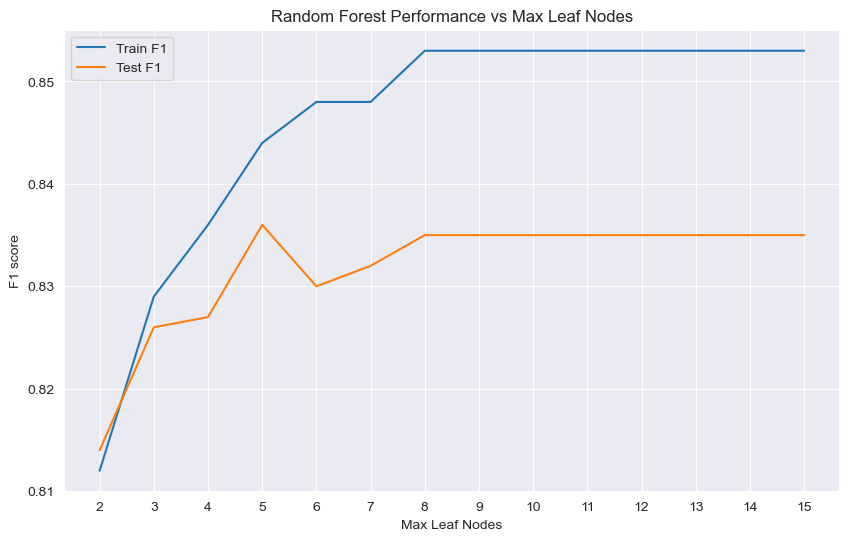

In [98]:
calculate_F1(X_train, y_train,X_test,y_test, np.arange(2, 16))

In [101]:
gb_best = GradientBoostingClassifier(max_leaf_nodes=5,subsample=0.5, min_samples_leaf=1, n_estimators=100, random_state=69)
gb_best.fit(X_train,y_train)
gb_best.score(X_train,y_train),gb_best.score(X_test,y_test)
print(f"Training Score: {round(100*gb_best.score(X_train, y_train),2)}%\nValidation Score: {round(100*gb_best.score(X_test, y_test),2)}%")

Training Score: 79.61%
Validation Score: 77.79%


## StackingClassifier - Extra

After seeing that the gradient boosting performed comparably to the Random Forest with less overfitting we chose to see what would happen if we stack them together and with a Logistic regression using liblinear and l1_ratio = 1. This turned out to be the most sucessfull model but it was yet to be discovered whether it was as good on kaggle as it was with Validation.

In [107]:
stack = StackingClassifier([('RandomForestClassifier', rf_best), ('GradientBoostingClassifier', gb_best)], final_estimator=LogisticRegression(solver='liblinear', l1_ratio=1))
stack.fit(X_train, y_train)
print(f"Training Score: {round(100*stack.score(X_train, y_train),2)}%\nValidation Score: {round(100*stack.score(X_test, y_test),2)}%")

Training Score: 87.49%
Validation Score: 77.88%


In [105]:
gb_pred=gb.predict(prediction_data)
gb_pred = pd.Series(gb_pred, index=prediction_data.index)
rf_pred=rf_best.predict(prediction_data)
rf_pred = pd.Series(rf_pred, index=prediction_data.index)
stack_pred = stack.predict(prediction_data)
stack_pred = pd.Series(stack_pred, index=prediction_data.index)
pred_all ={
    'GradientBoosting': gb_pred,
    'RandomForest': rf_pred,
    'StackingClassifier': stack_pred,
}
for name, pred in pred_all.items():
    pred.to_csv(f'Nata_Files/predictions/Final_{name}.csv')

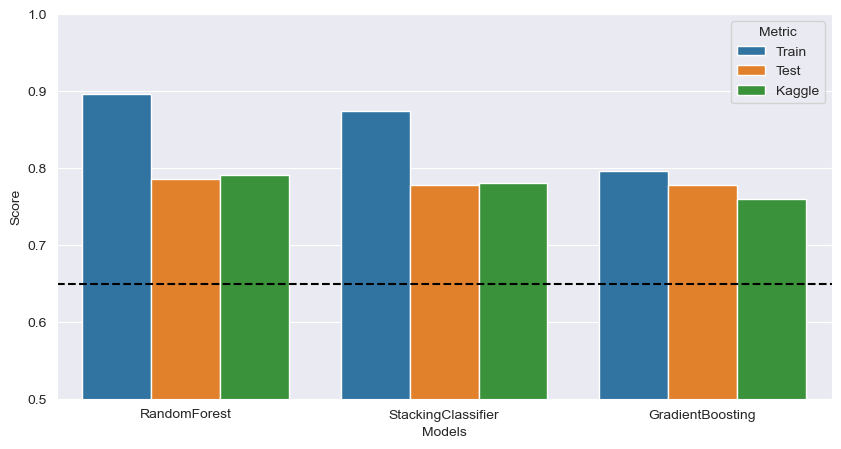

In [106]:
scores = {'GradientBoosting': [gb_best.score(X_train, y_train), gb_best.score(X_test, y_test), 0.76],
          'RandomForest':[rf_best.score(X_train, y_train), rf_best.score(X_test, y_test), 0.791],
          'StackingClassifier':[stack.score(X_train, y_train), stack.score(X_test, y_test), 0.781],
          }
df_scores = pd.DataFrame(scores, index=['Train','Test','Kaggle']).T.reset_index().rename({'index':'Models'}, axis=1)
df_scores.sort_values('Kaggle', ascending=False, inplace=True)
df_long = df_scores.melt(id_vars='Models',
                         value_vars=['Train', 'Test','Kaggle'],
                         var_name='Metric',
                         value_name='Score')
fig, ax = plt.subplots(figsize=(10, 5))
sns.barplot(df_long, x='Models', y='Score', hue='Metric', ax=ax)
plt.ylim(bottom=0.5,top=1)
plt.axhline(y=0.65, color='k', linestyle='--')
plt.show()